# David Gamaliel Arcos Bravo
# Luis Fernando Caro Reyna

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly
import numba
import random
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from numba import jit, cuda
from numba.typed import List

162
Best fitness:  162.0
Max fitness possible:  162
True


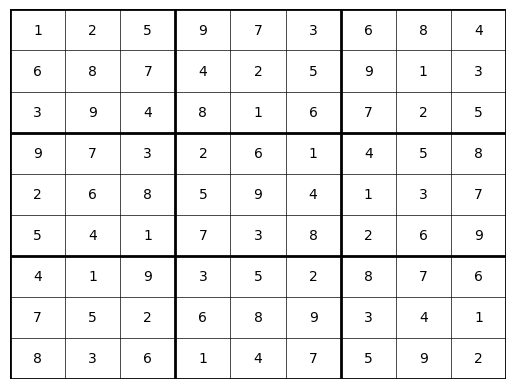

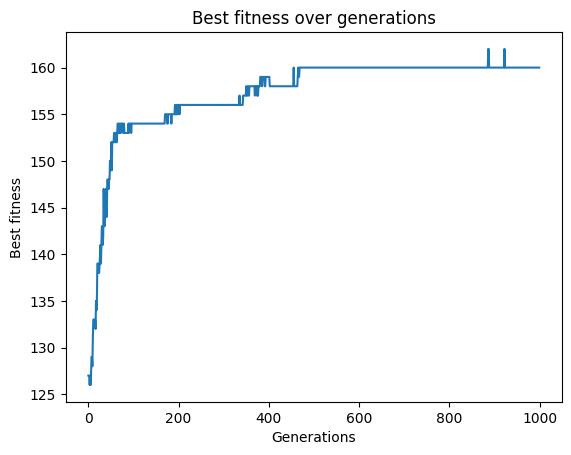

In [50]:
# Genetic algorithm function to solve a sudoku
def genetic_algorithm(population_size, generations, mutation_rate):
    population = initialize_population(population_size)
    fitness = np.zeros(population_size)
    best_fitness = np.zeros(generations)
    best_individual = np.zeros((generations, population[0].shape[0], population[0].shape[1]))
    for i in range(generations):
        children = np.zeros_like(population)
        for j in range(1, population_size):
            parent1 = population[tournament_selection(fitness.copy(), 5)]
            parent2 = population[tournament_selection(fitness.copy(), 5)]
            child = crossover(parent1.copy(), parent2.copy())
            child = mutate(child, mutation_rate)
            children[j] = child
            fitness[j] = fitness_function(children[j]) 
        best_individual_index = np.argmax(fitness)
        best_fitness[i] = fitness[best_individual_index]
        best_individual[i] = children[best_individual_index]
        children[0] = best_individual[i].copy()
        population = children.copy()
    return best_fitness, best_individual

def mutate(individual, mutation_rate):
    for i in range(3):
        for j in range(3):
            if np.random.rand() < mutation_rate:
                block = individual[i*3:i*3+3, j*3:j*3+3]
                block = block.flatten()
                index1 = np.random.randint(0, 9)
                index2 = np.random.randint(0, 9)
                block[index1], block[index2] = block[index2], block[index1]
                block = block.reshape(3, 3)
                individual[i*3:i*3+3, j*3:j*3+3] = block
    return individual

def crossover(parent1, parent2):
    child = np.zeros((9, 9), dtype=int)
    for i in range(3):
        for j in range(3):
            block = np.zeros((3, 3), dtype=int)
            if np.random.rand() < 0.5:
                block = parent1[i*3:i*3+3, j*3:j*3+3]
            else:
                block = parent2[i*3:i*3+3, j*3:j*3+3]
            child[i*3:i*3+3, j*3:j*3+3] = block
    return child

@jit(target_backend='cuda') 
def roulette_wheel_selection(fitness):
    fitness_sum = np.sum(fitness)
    fitness_normalized = fitness / fitness_sum
    random_value = np.random.rand()
    for i in range(len(fitness_normalized)):
        random_value -= fitness_normalized[i]
        if random_value <= 0:
            return i

@jit(target_backend='cuda') 
def tournament_selection(fitness, tournament_size):
    tournament = np.random.randint(0, len(fitness), tournament_size)
    best_index = np.argmax(fitness[tournament])
    return tournament[best_index]

@jit(target_backend='cuda') 
def fitness_function(individual):
    fitness = 0
    for i in range(9):
        row = individual[i, :]
        column = individual[:, i]
        row_values = np.unique(row)
        column_values = np.unique(column)
        fitness += len(row_values) + len(column_values)
    return fitness

def initialize_population(population_size):
    population = np.zeros((population_size, 9, 9), dtype=int)
    for i in range(population_size):
        individual = np.zeros((9, 9), dtype=int)
        for row in range(3):
            for column in range(3):
                block = np.random.permutation(np.arange(1, 10))
                block = block.reshape(3, 3)
                individual[row*3:row*3+3, column*3:column*3+3] = block
        population[i] = individual
    return population

def check_if_solved(individual):
    for i in range(9):
        row = individual[i, :]
        column = individual[:, i]
        row_values = np.unique(row)
        column_values = np.unique(column)
        block = individual[i//3*3:i//3*3+3, i%3*3:i%3*3+3]
        block_values = np.unique(block)
        if len(row_values) != 9:
            print('row',i)
            return False
        elif len(column_values) != 9:
            print('column',i)
            return False
        elif len(block_values) != 9:
            print('block',i)
            return False
    return True

def plot_sudoku(individual):
    fig, ax = plt.subplots()
    for i in range(9):
        for j in range(9):
            if individual[i, j] == 0:
                ax.add_patch(patches.Rectangle((i-0.5, j-0.5), 1, 1, fill=False))
            else:
                ax.text(i, j, individual[i, j].astype(int), ha='center', va='center')
    for i in range(10):
        ax.plot([i-0.5, i-0.5], [-0.5, 8.5], 'k-', lw=(2 if i % 3 == 0 else 0.5))
        ax.plot([-0.5, 8.5], [i-0.5, i-0.5], 'k-', lw=(2 if i % 3 == 0 else 0.5))
    plt.xlim(-0.5, 8.5)
    plt.ylim(-0.5, 8.5)
    ax.axis('off')
    plt.show()

def main():
    population_size = 100
    generations = 1000
    mutation_rate = 0.1
    best_fitness, best_individual = genetic_algorithm(population_size, generations, mutation_rate)
    best_index = np.argmax(best_fitness)
    print(fitness_function(best_individual[best_index]))
    print("Best fitness: ", best_fitness[best_index])
    print("Max fitness possible: ", 9*9*2)
    print(check_if_solved(best_individual[best_index]))
    plot_sudoku(best_individual[best_index])
    plt.plot(best_fitness)
    plt.xlabel('Generations')
    plt.ylabel('Best fitness')
    plt.title('Best fitness over generations')
    plt.show()

if __name__ == '__main__':
    main()